<a href="https://colab.research.google.com/github/robwil/fastai-deeplearning/blob/master/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is an attempt to use the FastAI Tabular Learner to predict future sales for a Kaggle competition. I previously used Random Forest model to achieve 0.89 RMSE and hoping to do better here.

Still TODO:
* Train with full dataset

In [0]:
from fastai.tabular import *

In [2]:
!wget http://staging.robwil.io/data.pkl

--2019-10-20 04:12:02--  http://staging.robwil.io/data.pkl
Resolving staging.robwil.io (staging.robwil.io)... 104.31.77.239, 104.31.76.239, 2606:4700:30::681f:4cef, ...
Connecting to staging.robwil.io (staging.robwil.io)|104.31.77.239|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 504588789 (481M) [application/octet-stream]
Saving to: ‘data.pkl’

data.pkl            100%[===================>] 481.21M  64.9MB/s    in 7.9s    

2019-10-20 04:12:10 (60.9 MB/s) - ‘data.pkl’ saved [504588789/504588789]



In [0]:
matrix = pd.read_pickle('data.pkl')

In [0]:
matrix = matrix.astype({'item_cnt_month':'float32','item_cnt_month_lag_1':'float32','item_cnt_month_lag_2':'float32','item_cnt_month_lag_3':'float32','item_cnt_month_lag_6':'float32','item_cnt_month_lag_12':'float32','date_avg_item_cnt_lag_1':'float32','date_item_avg_item_cnt_lag_1':'float32','date_item_avg_item_cnt_lag_2':'float32','date_item_avg_item_cnt_lag_3':'float32','date_item_avg_item_cnt_lag_6':'float32','date_item_avg_item_cnt_lag_12':'float32','date_shop_avg_item_cnt_lag_1':'float32','date_shop_avg_item_cnt_lag_2':'float32','date_shop_avg_item_cnt_lag_3':'float32','date_shop_avg_item_cnt_lag_6':'float32','date_shop_avg_item_cnt_lag_12':'float32','date_cat_avg_item_cnt_lag_1':'float32','date_shop_cat_avg_item_cnt_lag_1':'float32','date_shop_type_avg_item_cnt_lag_1':'float32','date_shop_subtype_avg_item_cnt_lag_1':'float32','date_city_avg_item_cnt_lag_1':'float32','date_item_city_avg_item_cnt_lag_1':'float32','date_type_avg_item_cnt_lag_1':'float32','date_subtype_avg_item_cnt_lag_1':'float32','delta_price_lag':'float32','delta_revenue_lag_1':'float32'})

In [5]:
df_train_full = matrix[matrix.date_block_num <= 33]
df_train_full['is_valid'] = df_train_full.date_block_num == 33
df_train = df_train_full.iloc[::90, :]
#df_valid = matrix[matrix.date_block_num == 33]
df_test = matrix[matrix.date_block_num == 34]

df_train_full.shape, df_train.shape, df_test.shape


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


((6425094, 41), (71390, 41), (214200, 40))

In [6]:
df_train.dtypes

date_block_num                             int8
shop_id                                    int8
item_id                                   int16
item_cnt_month                          float32
city_code                                  int8
item_category_id                           int8
type_code                                  int8
subtype_code                               int8
item_cnt_month_lag_1                    float32
item_cnt_month_lag_2                    float32
item_cnt_month_lag_3                    float32
item_cnt_month_lag_6                    float32
item_cnt_month_lag_12                   float32
date_avg_item_cnt_lag_1                 float32
date_item_avg_item_cnt_lag_1            float32
date_item_avg_item_cnt_lag_2            float32
date_item_avg_item_cnt_lag_3            float32
date_item_avg_item_cnt_lag_6            float32
date_item_avg_item_cnt_lag_12           float32
date_shop_avg_item_cnt_lag_1            float32
date_shop_avg_item_cnt_lag_2            

In [7]:
df_train.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,is_valid
4488710,12,2,27,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,0.955566,0.808594,0.935059,0.148071,0.0,1.034180,1.075195,-0.282715,1.211914,0,31,1,1,12,12,False
4488800,12,2,485,1.0,0,73,15,0,1.0,0.0,4.0,2.0,0.0,0.411377,2.412109,3.355469,3.716797,3.087891,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.407227,0.136353,0.083984,0.136353,0.148071,1.0,0.234741,0.407227,0.005901,1.211914,0,31,1,1,10,10,False
4488890,12,2,868,0.0,0,78,15,45,0.0,0.0,0.0,0.0,0.0,0.411377,0.021744,0.199951,0.086975,0.021744,0.000000,0.148071,0.100647,0.08905,0.096008,0.000000,0.031799,0.000000,0.083984,0.000000,0.148071,0.0,0.234741,0.031799,0.015022,1.211914,0,31,-1,1,7,7,False
4488980,12,2,1067,0.0,0,77,15,44,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.244385,0.000000,0.000000,0.00000,0.000000,0.141235,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0,31,4,4,12,12,False
4489070,12,2,1409,0.0,0,19,5,10,0.0,0.0,0.0,0.0,1.0,0.411377,0.043488,0.022217,0.021744,0.086975,0.666504,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,0.955566,0.808594,0.935059,0.148071,0.0,1.034180,1.075195,-0.009445,1.211914,0,31,1,1,12,12,False


In [8]:
df_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [0]:
dep_var = 'item_cnt_month'
cat_names = ['month', 'shop_id', 'item_id', 'city_code', 'item_category_id','type_code', 'subtype_code']
cont_names = ['date_block_num',
        'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta_revenue_lag_1', 'days', 'item_shop_last_sale',
       'item_last_sale', 'item_shop_first_sale', 'item_first_sale']
procs = [FillMissing, Categorify, Normalize]
y_range = [0, np.max(matrix[dep_var])*1.2]

In [0]:
test = TabularList.from_df(df_test, cat_names=cat_names, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(df_train_full, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_from_df('is_valid')
                           .label_from_df(cols=dep_var, label_cls = FloatList)
                           .add_test(test)
                           .databunch())

In [12]:
data.show_batch(rows=10)

month,shop_id,item_id,city_code,item_category_id,type_code,subtype_code,date_block_num,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale,target
9,19,15843,12,55,13,2,-0.0269,-0.2461,-0.2439,-0.2414,-0.2343,1.5246,-1.8185,-0.3514,-0.3222,-0.2694,-0.2560,0.3696,-1.0113,0.3205,0.1671,0.2206,0.6427,-0.5803,-0.4379,-0.6377,-0.4458,-1.2453,-0.2780,-0.9348,-0.5879,0.1806,-0.1315,0.6770,1.3657,-0.1200,1.1102,1.0062,0.0
8,25,6257,13,55,13,2,1.8472,-0.2461,-0.2439,-0.2414,-0.2343,-0.2102,-1.8185,-0.3514,-0.3453,-0.3390,-0.3258,-0.2842,-1.0113,-0.9813,-0.9437,-0.8719,-0.6895,-0.5803,-0.4379,-0.6377,-0.4458,-1.2453,-0.2780,-0.9348,-0.5879,0.1806,-0.1315,-0.4203,-0.8934,-0.1200,-1.4949,-1.5887,0.0
0,52,7161,25,58,13,27,-1.5603,-0.2461,-0.2439,-0.2414,-0.2343,-0.2102,1.3967,-0.3253,-0.3191,-0.3390,-0.3258,-0.2842,0.1073,-0.0667,-0.9437,-0.8719,-0.6895,-0.4302,-0.3937,-0.2461,-0.4008,0.3023,-0.2780,-0.0813,-0.4351,-0.5022,2.0123,0.6770,-0.8934,-0.1200,-1.2468,-1.3416,0.0
2,30,6569,13,19,5,10,-1.2195,-0.2461,0.5814,0.5763,-0.2343,-0.2102,0.5839,0.5361,0.4232,1.8027,-0.3258,-0.2842,0.2240,0.2703,0.6974,-0.8719,-0.6895,1.1874,0.5275,1.0457,0.4909,1.3211,0.9505,2.2230,1.0901,0.1741,-0.1192,0.6770,0.6127,-0.1200,-1.1227,-1.2180,0.0
7,31,9796,13,40,11,4,-0.3676,-0.2461,0.5814,-0.2414,0.5744,-0.2102,0.1717,-0.2794,-0.1289,-0.1260,0.0709,0.3843,3.0674,3.3029,3.3199,4.2806,4.2976,-0.1249,1.4675,1.6484,1.4949,0.8979,-0.1835,-0.2782,-0.1245,0.6760,-0.9094,0.6770,0.6127,-0.1200,0.6140,0.5120,2.0
7,6,20610,4,72,14,59,1.6769,-0.2461,0.5814,1.3940,0.5744,1.5246,0.2080,0.6814,0.5859,0.7149,0.9115,1.9810,0.1448,0.2514,0.2182,0.7310,1.0698,-0.1218,-0.2905,0.0471,-0.2956,0.1016,1.1397,0.2446,-0.1214,1.1648,-1.2063,0.6770,0.6127,-0.1200,0.9862,0.8827,0.0
1,6,10729,4,40,11,4,0.6546,0.5887,-0.2439,-0.2414,-0.2343,-0.2102,0.6621,-0.2074,-0.1332,-0.0608,0.1213,-0.2842,0.5343,1.4381,0.8342,0.7708,-0.6895,0.0879,0.0728,0.1148,0.0744,0.5364,0.1946,-0.0039,0.0919,0.6288,-0.5213,-2.6150,0.6127,-0.1200,-0.5025,-0.6002,0.0
0,5,18476,3,55,13,2,0.4842,-0.2461,1.4066,0.5763,5.4265,-0.2102,1.6524,0.7770,1.3515,1.4223,3.1400,-0.2842,0.2500,-0.0981,-0.1931,-0.0107,-0.6895,0.2168,0.0096,-0.1966,0.0100,0.3126,-0.2780,0.0639,0.2231,-0.7805,2.9756,0.6770,0.6127,-0.1200,-0.6265,-0.7237,0.0
7,56,4380,28,40,11,4,-0.3676,-0.2461,1.4066,0.5763,-0.2343,1.5246,0.1717,0.1767,0.5681,0.4653,0.2196,0.7850,0.4271,0.5800,0.2725,0.5121,1.1737,-0.1249,0.3354,0.2379,0.3418,0.5313,-0.2780,-0.2782,-0.1245,-0.7686,-0.3872,0.6770,0.6127,-0.1200,0.7381,0.6355,0.0
6,42,9833,19,40,11,4,-0.5380,-0.2461,-0.2439,-0.2414,-0.2343,-0.2102,-1.8185,-0.3514,-0.3212,-0.2680,-0.3010,-0.2319,-1.0113,1.0656,1.1390,1.2365,1.2291,-0.5803,-0.4379,-0.6377,-0.4458,-1.2453,-0.2780,-0.9348,-0.5879,0.1806,-0.1315,0.6770,-0.8934,-0.1200,0.7381,0.6355,0.0


In [0]:
learn = tabular_learner(data, layers=[200,100], y_range=y_range, metrics=rmse)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


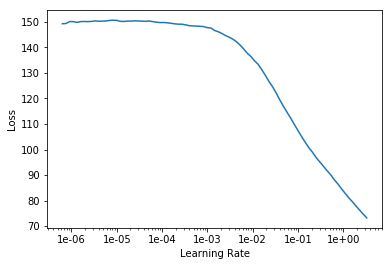

In [15]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr = 1e-1)

epoch,train_loss,valid_loss,root_mean_squared_error,time


In [0]:
learn.save('full_stage1')

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=1e-03)

In [0]:
learn.save('full_stage2')

# Submission

In [0]:
!gunzip test.csv.gz

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)


In [0]:
pred_probs, _ = preds.max(1)

In [0]:
test_file = pd.read_csv('test.csv').set_index('ID')

In [0]:

submission = pd.DataFrame({
    "ID": test_file.index, 
    "item_cnt_month": pred_probs
})
submission.to_csv('nn_submission.csv', index=False)


In [0]:
!head nn_submission.csv

In [297]:
df_test.head()

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
10913804,34,5,5037,0.0,3,19,5,10,0.0,1.0,3.0,1.0,1.0,0.258545,0.568359,2.511719,2.833984,1.977539,1.299805,0.190063,0.205933,0.245117,0.180054,0.206055,0.379150,0.513672,0.456055,0.447021,0.190063,0.0,0.494141,0.337402,-0.222046,-0.048553,10,30,1,1,14,14
10913805,34,5,5320,0.0,3,55,13,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10,30,-1,-1,0,0
10913806,34,5,5233,0.0,3,19,5,10,1.0,3.0,1.0,3.0,0.0,0.258545,0.954590,1.860352,3.572266,1.613281,0.000000,0.190063,0.205933,0.245117,0.180054,0.000000,0.379150,0.513672,0.456055,0.447021,0.190063,1.0,0.494141,0.337402,0.496826,-0.048553,10,30,1,1,7,7
10913807,34,5,5232,0.0,3,23,5,16,0.0,0.0,1.0,0.0,0.0,0.258545,0.636230,1.116211,1.547852,0.000000,0.000000,0.190063,0.205933,0.245117,0.000000,0.000000,0.337402,0.374268,0.456055,0.349121,0.190063,0.0,0.494141,0.331787,0.505371,-0.048553,10,30,1,1,3,3
10913808,34,5,5268,0.0,3,20,5,11,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,10,30,-1,-1,0,0


In [298]:
test_file.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
